## Multiple Linear Regression
### and backward elimination
#### economics indicators

The purpose of this notebook is to 
* apply Multiple Linear Regression to the preprocessed dataset
* apply backward elimination to the model
* ultimately find out the independent variables (World Development Idicators) which influence the dependent variable (Happy Planet Index) the most.

The model will be applied to the "wdi_hpi_2016_economics" dataset, which was created in the Data Preprocessing JNotebook. This dataset is based on
* the Happy Planet Index for 2016 (see https://happyplanetindex.org/),
* the World Development Indicators (1960 - 2019) by the World Bank (see https://datacatalog.worldbank.org/dataset/world-development-indicators)

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import dataset
dataset = pd.read_pickle('../data/wdi_hpi_2016_economics.pkl')
picture_name = '../data/pictures/Economics_corr.jpg'

In [3]:
# Standardize data for the model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit dataset to scaler object
dataset_scaled = dataset.iloc[:, 1:].values    # Exclude Country column 
scaler.fit(dataset_scaled)

# Transform data into scaled data
dataset_scaled = pd.DataFrame(scaler.transform(dataset_scaled))

In [4]:
# Split dataset into X (matrix of independent variables) and y (vector of dependent variable)
X = dataset_scaled.iloc[:, 1:-1].values
y = dataset_scaled.iloc[:, dataset_scaled.shape[1]-1].values

# Split datasets into Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.0)    # no split, as model is not used for prediction

In [5]:
# Fit Multiple Linear Regression Model to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
# Predict the Test set results
#y_pred = regressor.predict(X_test)

In [7]:
# Reduce less important variables with Backward Elimination
import statsmodels.regression.linear_model as sm

# for statsmodel to understand the multiple linear regression equation a new column with b0 equals one is required (y = b0 + b1*x1 + b2*x2 + ... + bn*xn)
X_opt = np.append(arr = np.ones((len(X), 1)).astype(int), values = X, axis = 1)   # Add X to the newly created array of 1s
#X_opt = X_opt[:, list(range(X_opt.shape[1]))]

X_cols = dataset.columns[1:-1].tolist()    # save headers to determin most important variables later
X_cols.insert(0,'b0')

X_mod1, X_mod2 = X_opt.copy(), X_opt.copy()
X_cols_mod1, X_cols_mod2 = X_cols.copy(), X_cols.copy()

regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     2.826
Date:                Tue, 03 Mar 2020   Prob (F-statistic):            0.00458
Time:                        16:39:58   Log-Likelihood:                -184.73
No. Observations:                 139   AIC:                             389.5
Df Residuals:                     129   BIC:                             418.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.012e-16      0.080   -2.5e-15      1.000      -0.159       0.159
x1            -0.0339      0.097     -0.348      0.728      -0.226       0.159
x2            -0.1219      0.091     -1.334      0.185      -0.303       0.059
x3         -1.203e+13   2.58e+13     -0.466      0.642   -6.31e+13    3.91e+13
x4          -3.04e+12   6.53e+12     -0.466      0.642    -1.6e+13    9.88e+12
x5          1.227e+13   2.63e+13      0.466      0.642   -3.99e+13    6.44e+13
x6            -0.3692      0.117     -3.163      0.002      -0.600      -0.138
x7             0.1566      0.104      1.504      0.135      -0.049       0.363
x8            -0.1386      0.103     -1.346      0.181      -0.342       0.065
x9             0.0779      0.082      0.954      0.342      -0.084       0.239
x10           -0.0010      0.150     -0.007      0.995      -0.298       0.296
==============================================================================
Omnibus:                        1.557   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.459   Jarque-Bera (JB):                1.446
Skew:                           0.132   Prob(JB):                        0.485
Kurtosis:                       2.576   Cond. No.                     7.91e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.41e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [8]:
# Fuction to automatically remove columns where P-value is below significance level of 5%
def backward_elimination(x, X_cols_mod, significance = 0.05):
    num_vars = len(x[0])
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(endog = y, exog = x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        if max_var > significance:
            for j in range(0, num_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    x = np.delete(x, j, 1)
                    X_cols_mod.pop(j)
    regressor_OLS.summary()
    return x, X_cols_mod
             
backward_elimination(X_mod1, X_cols_mod1)
print(X_cols_mod1)

['IP.JRN.ARTC.SC', 'NE.TRD.GNFS.ZS', 'NY.GDP.PCAP.PP.CD']


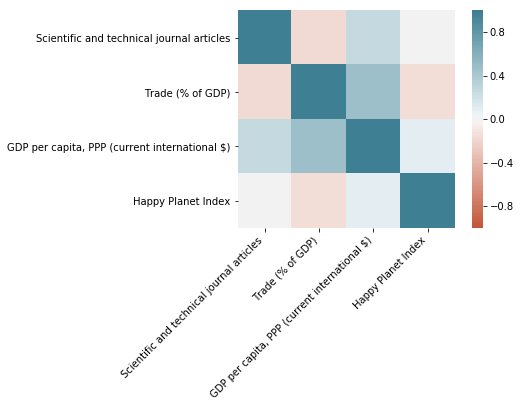

In [9]:
# Create Correlation Matrix with Seaborn (only remaining columns from backward elimination)

# Translate WDI abbreviations into meaningsful indicator descriptions
chosen_columns = pd.read_pickle('../data/WDI_chosen_columns.pkl')

corr_cols_descr = []
for ind in X_cols_mod1:
    descr = chosen_columns['Indicator Name'][chosen_columns['Indicator Code'] == ind].to_string(index = False)
    corr_cols_descr.append(descr)
corr_cols_descr.append('Happy Planet Index')

# Import Seaborn and plot Correlation Matrix
import seaborn as sns

corr_cols = X_cols_mod1.copy()
corr_cols.append('Happy Planet Index')
corr = dataset[corr_cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    yticklabels = corr_cols_descr,
    xticklabels = corr_cols_descr
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
# Fuction to automatically remove columns where P-value is below significance level of 5%
# and adjusted R² is improved
def backward_elimination_r2(x, X_cols_mod, significance = 0.05):
    num_vars = len(x[0])
    temp = np.zeros((x.shape)).astype(int)
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(endog = y, exog = x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if max_var > significance:
            for j in range(0, num_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, axis = 1)
                    tmp_col = X_cols_mod.pop(j)
                    tmp_regressor = sm.OLS(endog = y, exog = x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        X_cols_rollback = X_cols_mod.append(tmp_col)
                        #x = np.hstack((x, temp[:,[0,j]]))
                        #x = np.delete(x, j, 1)
                        #X_cols_mod = X_cols_mod.append(tmp_col)
                        print (regressor_OLS.summary())
                        return x_rollback, X_cols_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x, X_cols_mod
    
backward_elimination_r2(X_mod2, X_cols_mod2)
print(X_cols_mod2)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     3.703
Date:                Tue, 03 Mar 2020   Prob (F-statistic):            0.00109
Time:                        16:39:58   Log-Likelihood:                -184.77
No. Observations:                 139   AIC:                             383.5
Df Residuals:                     132   BIC:                             404.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1321      0.085     -1.560      0.1

,GB.XPD.RSDV.GD.ZS,IP.JRN.ARTC.SC,NE.IMP.GNFS.ZS,NE.TRD.GNFS.ZS,NV.AGR.TOTL.ZS,NV.IND.MANF.ZS,NV.IND.TOTL.ZS,NY.GDP.PCAP.PP.CD,NE.RSB.GNFS.ZS,Happy Planet Index
GB.XPD.RSDV.GD.ZS,1.000000,0.362580,-0.052084,-0.007372,-0.207551,0.138157,-0.086347,0.434116,0.176271,0.039113
IP.JRN.ARTC.SC,0.362580,1.000000,-0.204092,-0.161365,-0.179986,0.195860,0.036607,0.258330,0.156201,0.008910
NE.IMP.GNFS.ZS,-0.052084,-0.204092,1.000000,0.968868,-0.173183,-0.140082,-0.151217,0.328143,-0.046267,-0.194569
NE.TRD.GNFS.ZS,-0.007372,-0.161365,0.968868,1.000000,-0.300121,-0.050373,-0.118355,0.471377,0.202486,-0.151914
NV.AGR.TOTL.ZS,-0.207551,-0.179986,-0.173183,-0.300121,1.000000,-0.323849,-0.242511,-0.637587,-0.525911,-0.265178
NV.IND.MANF.ZS,0.138157,0.195860,-0.140082,-0.050373,-0.323849,1.000000,0.538258,0.156489,0.350846,0.190743
NV.IND.TOTL.ZS,-0.086347,0.036607,-0.151217,-0.118355,-0.242511,0.538258,1.000000,-0.097724,0.120595,0.070904
NY.GDP.PCAP.PP.CD,0.434116,0.258330,0.328143,0.471377,-0.637587,0.156489,-0.097724,1.000000,0.603959,0.090915
NE.RSB.GNFS.ZS,0.176271,0.156201,-0.046267,0.202486,-0.525911,0.350846,0.120595,0.603959,1.000000,0.156666
Happy Planet Index,0.039113,0.008910,-0.194569,-0.151914,-0.265178,0.190743,0.070904,0.090915,0.156666,1.000000


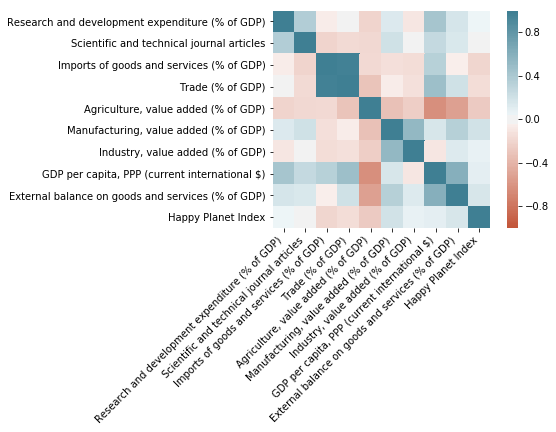

In [11]:
# Create Correlation Matrix with Seaborn

# Translate WDI abbreviations into meaningsful indicator descriptions
corr_cols_descr = []
for ind in X_cols_mod2:
    descr = chosen_columns['Indicator Name'][chosen_columns['Indicator Code'] == ind].to_string(index = False)
    corr_cols_descr.append(descr)
corr_cols_descr.append('Happy Planet Index')

corr_cols = X_cols_mod2.copy()
corr_cols.append('Happy Planet Index')
corr = dataset[corr_cols].corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    yticklabels = corr_cols_descr,
    xticklabels = corr_cols_descr
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Save Correlation Matrix to 
plt.savefig(picture_name, format = 'jpg', optimize = True, bbox_inches = 'tight')

# Return Correlation Matrix
corr